 # Import Libraries

In [4]:
!conda list

# packages in environment at C:\Users\UX533F\anaconda3\envs\tf:
#
# Name                    Version                   Build  Channel
_tflow_select             2.3.0                     eigen  
absl-py                   0.11.0             pyhd3eb1b0_1  
appdirs                   1.4.4                    pypi_0    pypi
argon2-cffi               20.1.0           py38he774522_1  
astunparse                1.6.3                      py_0  
async_generator           1.10                       py_0  
attrs                     20.3.0             pyhd3eb1b0_0  
audioread                 2.1.9                    pypi_0    pypi
backcall                  0.2.0                      py_0  
blas                      1.0                         mkl  
bleach                    3.2.1                      py_0  
blinker                   1.4                      py38_0  
brotlipy                  0.7.0           py38h2bbff1b_1003  
ca-certificates           2020.12.8            haa95532_0  
cachetools   

urllib3                   1.25.11                    py_0  
vc                        14.2                 h21ff451_1  
vs2015_runtime            14.27.29016          h5e58377_2  
wcwidth                   0.2.5                      py_0  
webencodings              0.5.1                    py38_1  
werkzeug                  1.0.1                      py_0  
wheel                     0.36.1             pyhd3eb1b0_0  
widgetsnbextension        3.5.1                    py38_0  
win_inet_pton             1.1.0            py38haa95532_0  
wincertstore              0.2                      py38_0  
winpty                    0.4.3                         4  
wrapt                     1.12.1           py38he774522_1  
xz                        5.2.5                h62dcd97_0  
zeromq                    4.3.3                ha925a31_3  
zipp                      3.4.0              pyhd3eb1b0_0  
zlib                      1.2.11               h62dcd97_4  
zstd                      1.4.5         

In [6]:
import numpy as np
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools

#AUDIO
import IPython.display as ipd # load a local WAV file and PLAY!!!
import librosa
import librosa.display

#SKELEARN
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

#FILTER
from scipy.signal import butter , filtfilt

#TENSORFLOW
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Build Dataset

*Create a dataset with set_a and set_b files.*

*We get 462 files instead of 832 after removing **unclassified sounds** and audios that are **shorter than 2 sec**.*

In [7]:
dataset = []
for folder in ["inputsound/set_a/**","inputsound/set_b/**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            # skip audio smaller than 3 secs
            if librosa.get_duration(filename=filename)>=4:
                #skip unknow heartbeat
                if label not in ["Aunlabelledtest", "Bunlabelledtest"]:
                    dataset.append({
                        "filename": filename,
                        "label": label
                    })
df = pd.DataFrame(dataset)
df = shuffle(df, random_state=42)

In [8]:
print(df.label.unique())
df.head()

['murmur' 'normal' 'artifact' 'extrahls' 'extrastole']


,filename,label
70,inputsound/set_a\murmur__201108222231.wav,murmur
218,inputsound/set_b\normal_noisynormal_101_130503...,normal
384,inputsound/set_b\normal__194_1308139824187_A1.wav,normal
33,inputsound/set_a\artifact__201106171003.wav,artifact
42,inputsound/set_a\extrahls__201101152255.wav,extrahls


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404 entries, 70 to 102
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  404 non-null    object
 1   label     404 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB


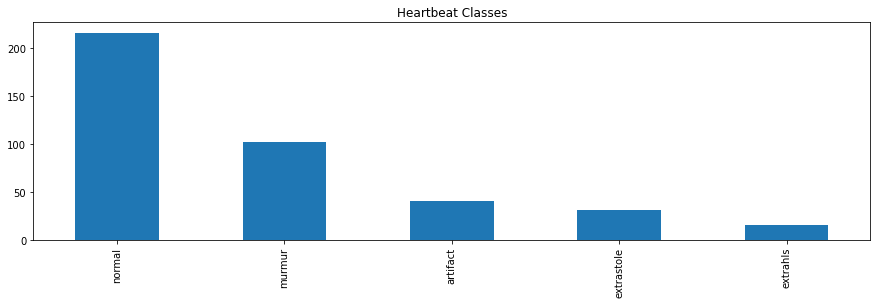

In [10]:
plt.figure(figsize=(15,4))
df.label.value_counts().plot(kind='bar', title="Heartbeat Classes")
plt.show()

# Train and test datasets

In [11]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

print(f"Training size = {len(train)}\nTesting size =  {len(test)}")

Training size = 323
Testing size =  81


# Get features from audio: [X_train  ,  X_test]

In [12]:
def get_features(path):
    signal, sr = librosa.load(path, duration=4)
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)
    return mfccs

In [13]:
# testing tqdm library
X_train, X_test = [], []

print("Extracting features from train and test dataset:")
for element in tqdm(range(len(train))):
    X_train.append(get_features(train.filename.iloc[element]))

for element in tqdm(range(len(test))):
    X_test.append(get_features(test.filename.iloc[element]))
    
    
X_test = np.asarray(X_test)
X_train = np.asarray(X_train)

print("X train:", X_train.shape)
print("X test:", X_test.shape)

  0%|                                                                                          | 0/323 [00:00<?, ?it/s]

Extracting features from train and test dataset:


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [00:13<00:00,  6.00it/s]

X train: (323, 40, 173)
X test: (81, 40, 173)


# LabelEncoder : [y_train,   y_test]

In [14]:
encoder = LabelEncoder()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

In [18]:
X_test[0]

array([[-472.32687   , -483.42227   , -494.30096   , ..., -500.7066    ,
        -502.67438   , -502.4628    ],
       [ 224.08806   ,  228.31122   ,  223.70694   , ...,  216.56937   ,
         214.95605   ,  213.43936   ],
       [  24.1897    ,   35.91434   ,   38.794525  , ...,   34.20146   ,
          35.21131   ,   32.36803   ],
       ...,
       [  -3.0960789 ,   -2.7030425 ,   -2.3148794 , ...,    3.0703897 ,
           1.7643913 ,   -1.5522223 ],
       [  -4.669224  ,   -2.3088984 ,   -1.1551976 , ...,    3.4381227 ,
           4.2331104 ,    4.569582  ],
       [  -3.6756122 ,   -2.6843233 ,   -3.7499132 , ...,   -2.0849762 ,
           0.59368336,    5.511444  ]], dtype=float32)

Due to the difference in the occurrence of each class, the algorithms tend to get biased towards the majority values (normal) present and don’t perform well on the minority values.

This difference in class frequencies is called class imbalance, and it affects the overall predictability of the model. 

In [19]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

C:\Users\UX533F\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1 2 3 4], y=[4 4 0 0 3 3 4 3 4 3 3 4 4 0 2 4 0 0 0 4 4 0 3 4 3 4 4 4 3 4 4 0 4 3 4 4 4
 3 4 4 4 4 3 0 4 4 4 2 4 3 4 3 3 3 3 4 4 3 4 0 3 3 1 3 4 3 4 4 3 2 2 4 1 3
 4 4 4 4 0 4 3 4 4 4 3 4 2 4 3 0 4 4 3 4 4 4 3 4 0 4 4 4 4 3 2 4 3 4 4 4 3
 0 4 4 2 4 3 0 4 3 4 2 4 4 3 4 2 3 3 4 3 4 4 3 3 4 4 4 4 3 3 3 1 4 4 3 3 3
 4 4 4 4 4 2 4 3 4 4 3 4 4 3 4 0 2 4 0 0 1 4 4 0 4 2 3 4 4 3 3 2 4 3 3 4 4
 3 4 2 4 4 4 4 0 4 4 3 4 4 4 4 4 3 1 4 4 4 2 4 4 4 4 4 3 4 0 3 4 4 3 4 4 3
 4 3 3 4 0 2 4 4 4 4 3 3 4 3 4 4 4 4 0 2 4 0 3 4 3 4 4 4 4 4 4 4 4 2 3 0 1
 4 2 4 4 4 3 4 1 4 4 0 4 4 1 3 1 4 4 0 4 2 2 4 4 4 4 2 4 4 4 4 2 0 3 0 4 4
 4 0 4 4 4 3 3 1 2 4 4 0 2 4 3 4 4 3 4 4 3 4 4 3 4 1 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [20]:
class_weights.shape

(5,)

# Reshaping inputs

In [21]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
#Converts a class vector (integers) to binary class matrix.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)



print("X train = ", X_train.shape)
print("y train = ", y_train.shape)
print("X test  = ", X_test.shape)
print("y test  = ", y_test.shape)

X train =  (323, 40, 173, 1)
y train =  (323, 5)
X test  =  (81, 40, 173, 1)
y test  =  (81, 5)


# Model

In [22]:
model = Sequential()
# 1 layer
model.add(Conv2D(filters=16, kernel_size=2, 
                 input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3]), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# 2 layer
model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# 3 layer
model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# 4 layer
model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

# Output layer
model.add(Dense(len(encoder.classes_), activation='softmax'))
#model.summary()

#### Compile

In [23]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=0.1))

#### Fit model

In [24]:
%%time
history = model.fit(x = X_train, y = y_train,
              batch_size=128,
              epochs=300,
              validation_data= (X_test,y_test),
              class_weight=class_weights,
              shuffle=True)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()